# Metamodel comparison, formulated as AUROC calculated for each class vs the rest (OvR)

To make AUCs comparable, model2 abstentions are carried through to model1 and model3 (within a BCR, TCR, or BCR+TCR setting).

So you can compare BCR model1/2/3/1+2/2+3/1+3/1+2+3 apples-to-apples. And same for TCR and for BCR+TCR. (Note that each gene locus setting may have a different sample size, due to BCR-only cohorts.)

This loads scores produced by `analyze_metamodels.ipynb`

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from malid import config, logger
from malid.train import train_metamodel
from malid.datamodels import (
    TargetObsColumnEnum,
    GeneLocus,
    map_cross_validation_split_strategy_to_default_target_obs_column,
)
from malid.trained_model_wrappers import BlendingMetamodel
import genetools
from IPython.display import display, Markdown
from slugify import slugify

In [2]:
base_model_train_fold_name = "train_smaller"
metamodel_fold_label_train = "validation"

In [3]:
def load(gene_locus: GeneLocus, target_obs_column: TargetObsColumnEnum):
    def _load(metamodel_flavor: str):
        # should already exist:
        highres_output_base_dir = (
            config.paths.high_res_outputs_dir
            / "metamodel"
            / gene_locus.name
            / target_obs_column.name
            / metamodel_flavor
        )
        fname_prefix = f"{base_model_train_fold_name}_applied_to_{metamodel_fold_label_train}_model"
        highres_results_output_prefix = highres_output_base_dir / fname_prefix

        df_ovr = pd.read_csv(
            f"{highres_results_output_prefix}.per_class_roc_auc_scores_ovr.tsv",
            sep="\t",
            index_col=0,
        )
        df_standard = pd.read_csv(
            f"{highres_results_output_prefix}.standard_scores_with_forced_consistent_abstentions.tsv",
            sep="\t",
            index_col=0,
        )

        return (metamodel_flavor, df_ovr, df_standard)

    try:
        flavors = train_metamodel.get_metamodel_flavors(
            gene_locus=gene_locus,
            target_obs_column=target_obs_column,
            fold_id=config.all_fold_ids[0],
            base_model_train_fold_name=base_model_train_fold_name,
            use_stubs_instead_of_submodels=True,
        )
    except Exception as err:
        logger.warning(
            f"Failed to generate metamodel flavors for {gene_locus}, {target_obs_column}: {err}"
        )
        return

    for metamodel_flavor in flavors.keys():
        try:
            yield _load(
                metamodel_flavor=metamodel_flavor,
            )
        except Exception as err:
            logger.error(
                f"Failed to load {gene_locus}, {target_obs_column}, {metamodel_flavor}: {err}"
            )

In [4]:
target_obs_column = map_cross_validation_split_strategy_to_default_target_obs_column[
    config.cross_validation_split_strategy
]
target_obs_column

<TargetObsColumnEnum.disease: TargetObsColumn(obs_column_name='disease', is_target_binary_for_repertoire_composition_classifier=False, available_for_cross_validation_split_strategies={<CrossValidationSplitStrategy.adaptive_peak_disease_timepoints: CrossValidationSplitStrategyValue(data_sources_keep=[<DataSource.adaptive: 2>], stratify_by='disease', diseases_to_keep_all_subtypes=['Covid19', 'CVID', 'Healthy/Background', 'HIV', 'T1D'], subtypes_keep=['RA - sero-positive'], filter_specimens_func_by_study_name={}, gene_loci_supported=<GeneLocus.TCR: 2>, exclude_study_names=[], include_study_names=None, filter_out_specimens_funcs_global=[], study_names_for_held_out_set=None)>, <CrossValidationSplitStrategy.in_house_peak_disease_timepoints: CrossValidationSplitStrategyValue(data_sources_keep=[<DataSource.in_house: 1>], stratify_by='disease', diseases_to_keep_all_subtypes=['Healthy/Background', 'HIV', 'Lupus', 'T1D'], subtypes_keep=['Covid19 - Sero-positive (ICU)', 'Covid19 - Sero-positive (A

In [5]:
dfs = []
for gene_locus in config.gene_loci_used:
    print(gene_locus)
    GeneLocus.validate_single_value(gene_locus)
    for metamodel_flavor, df_ovr, df_standard in load(
        gene_locus=gene_locus, target_obs_column=target_obs_column
    ):
        dfs.append(((gene_locus, metamodel_flavor), (df_ovr, df_standard)))

# Together in combined metamodel
if len(config.gene_loci_used) > 1:
    print(config.gene_loci_used)
    for metamodel_flavor, df_ovr, df_standard in load(
        gene_locus=config.gene_loci_used, target_obs_column=target_obs_column
    ):
        dfs.append(((config.gene_loci_used, metamodel_flavor), (df_ovr, df_standard)))


dfs = dict(dfs)
len(dfs)

GeneLocus.BCR
GeneLocus.TCR
GeneLocus.BCR|TCR


23

In [6]:
dfs.keys()

dict_keys([(<GeneLocus.BCR: 1>, 'default'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_repertoire_stats'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_convergent_cluster_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_sequence_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_repertoire_stats_convergent_cluster_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_repertoire_stats_sequence_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_convergent_cluster_model_sequence_model'), (<GeneLocus.BCR: 1>, 'isotype_counts_only'), (<GeneLocus.TCR: 2>, 'default'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_repertoire_stats'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_convergent_cluster_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_sequence_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_repertoire_stats_convergent_cluster_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_repertoire_stats_sequence_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_convergent_cluster_model_sequence_model

In [7]:
# Check sample sizes for each model - we want number of abstentions to be the same for all flavors from the same GeneLocus
sample_sizes = []
for (gene_locus, metamodel_flavor), (df_ovr, df_standard) in dfs.items():
    n_abstentions = df_standard["n_abstentions"].iloc[0]
    n_total = df_standard["sample_size including abstentions"].iloc[0]

    # sanity check that each row has same numbers
    assert (df_standard["n_abstentions"] == n_abstentions).all()
    assert (df_standard["sample_size including abstentions"] == n_total).all()

    #     print(
    #         f"{gene_locus}, flavor {metamodel_flavor}: {n_abstentions} / {n_total} abstained"
    #     )
    sample_sizes.append(
        dict(
            gene_locus=gene_locus.name,
            metamodel_flavor=metamodel_flavor,
            n_abstentions=n_abstentions,
            n_total=n_total,
        )
    )
sample_sizes = pd.DataFrame(sample_sizes)
sample_sizes

,gene_locus,metamodel_flavor,n_abstentions,n_total
0,BCR,default,15,616
1,BCR,subset_of_submodels_repertoire_stats,15,616
2,BCR,subset_of_submodels_convergent_cluster_model,15,616
3,BCR,subset_of_submodels_sequence_model,15,616
4,BCR,subset_of_submodels_repertoire_stats_convergen...,15,616
5,BCR,subset_of_submodels_repertoire_stats_sequence_...,15,616
6,BCR,subset_of_submodels_convergent_cluster_model_s...,15,616
7,BCR,isotype_counts_only,15,616
8,TCR,default,2,550
9,TCR,subset_of_submodels_repertoire_stats,2,550


In [8]:
# Confirm number of abstentions to be the same for all flavors from the same GeneLocus:
# (If this fails, this likely means we failed to train the metamodel for a particular fold, likely due to a silent failure to train a base model for that fold.
# Look for "Failed to create ... metamodel flavor" in metamodel train logs.)
for locus, grp in sample_sizes.groupby("gene_locus"):
    print("Checking", locus)
    assert grp["n_abstentions"].nunique() == 1
    assert grp["n_total"].nunique() == 1

Checking BCR
Checking BCR_TCR
Checking TCR


In [9]:
# Combine OvR and standard AUROC scores
dfs = {
    (gene_locus, metamodel_flavor): pd.concat(
        [
            df_ovr,
            df_standard["ROC-AUC (weighted OvO) per fold"].rename("Average (OvO)"),
        ],
        axis=1,
    )
    for (gene_locus, metamodel_flavor), (df_ovr, df_standard) in dfs.items()
}

In [10]:
dfs.keys()

dict_keys([(<GeneLocus.BCR: 1>, 'default'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_repertoire_stats'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_convergent_cluster_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_sequence_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_repertoire_stats_convergent_cluster_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_repertoire_stats_sequence_model'), (<GeneLocus.BCR: 1>, 'subset_of_submodels_convergent_cluster_model_sequence_model'), (<GeneLocus.BCR: 1>, 'isotype_counts_only'), (<GeneLocus.TCR: 2>, 'default'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_repertoire_stats'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_convergent_cluster_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_sequence_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_repertoire_stats_convergent_cluster_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_repertoire_stats_sequence_model'), (<GeneLocus.TCR: 2>, 'subset_of_submodels_convergent_cluster_model_sequence_model

In [11]:
locus_order = []
if GeneLocus.BCR in config.gene_loci_used:
    locus_order.append("BCR")
if GeneLocus.TCR in config.gene_loci_used:
    locus_order.append("TCR")
if GeneLocus.BCR in config.gene_loci_used and GeneLocus.TCR in config.gene_loci_used:
    locus_order.append("BCR+TCR")
model_order = ["1", "2", "3", "1+2", "1+3", "2+3", "1+2+3"]
locus_order

['BCR', 'TCR', 'BCR+TCR']

In [12]:
def subset_for_model(name: str):
    # TODO: don't construct a string here. keep it as a tuple to simplify cols_expanded below
    df_per_model = pd.concat(
        [
            df.loc[name].rename(
                f"{metamodel_flavor} - {gene_locus.name.replace('_', '+')}"
            )
            for (gene_locus, metamodel_flavor), df in dfs.items()
        ],
        axis=1,
    )
    # Remove +/- stddev across cross validation folds
    df_per_model = df_per_model.apply(
        lambda ser: ser.str.split(" +/-", regex=False).str[0].astype(float)
    )

    # Drop isotype_counts
    df_per_model = df_per_model[
        df_per_model.columns[
            ~df_per_model.columns.str.startswith("isotype_counts_only")
        ]
    ]
    # Rename others to shorter descriptions of which model is used
    rename_dict = {
        "default": "1+2+3",
        "subset_of_submodels_repertoire_stats": "1",
        "subset_of_submodels_convergent_cluster_model": "2",
        "subset_of_submodels_sequence_model": "3",
        "subset_of_submodels_repertoire_stats_convergent_cluster_model": "1+2",
        "subset_of_submodels_repertoire_stats_sequence_model": "1+3",
        "subset_of_submodels_convergent_cluster_model_sequence_model": "2+3",
    }
    cols_expanded = df_per_model.columns.to_series().str.split(" - ", expand=True)
    cols_expanded[0] = cols_expanded[0].map(rename_dict)
    df_per_model.columns = cols_expanded.values

    # Sort by second component (BCR, TCR, BCR+TCR),
    # then by model number within the second component group,
    # providing a custom sort order.
    def _list_to_sort_order_dict(lst):
        # {'val1': 0, 'val2': 1, ...}
        return dict(zip(lst, range(len(lst))))

    locus_sort_order = _list_to_sort_order_dict(locus_order)
    model_sort_order = _list_to_sort_order_dict(model_order)
    df_per_model = df_per_model.reindex(
        sorted(
            df_per_model.columns,
            key=lambda col: (locus_sort_order[col[1]], model_sort_order[col[0]]),
        ),
        axis=1,
    )

    tuple_columns = df_per_model.columns.tolist()

    # Combine sorted column names into single strings.
    df_per_model.columns = df_per_model.columns.to_series().apply("\n".join).values

    # Sort the rows (diseases)
    df_per_model.sort_index(axis="index", inplace=True)

    return df_per_model, tuple_columns

In [13]:
sns.set_context("paper", font_scale=0.9)  # Smaller font size

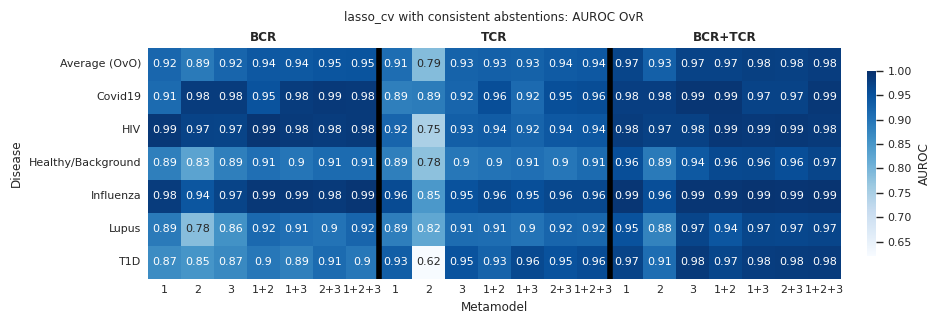

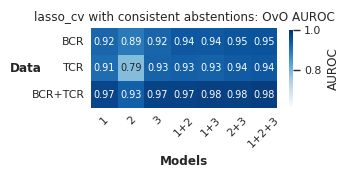

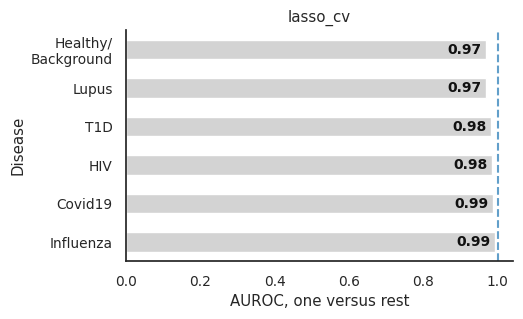

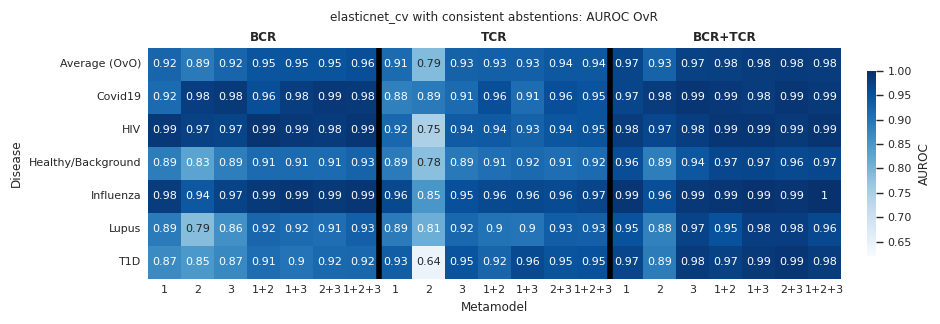

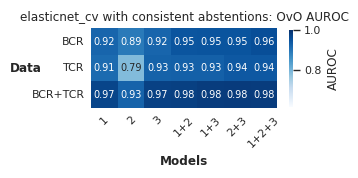

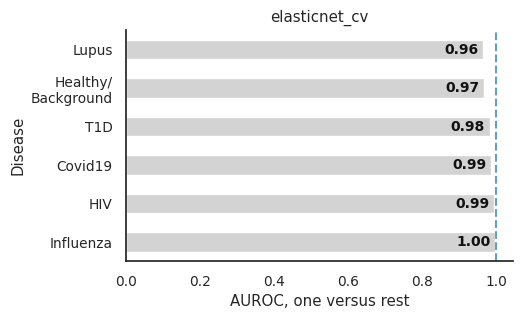

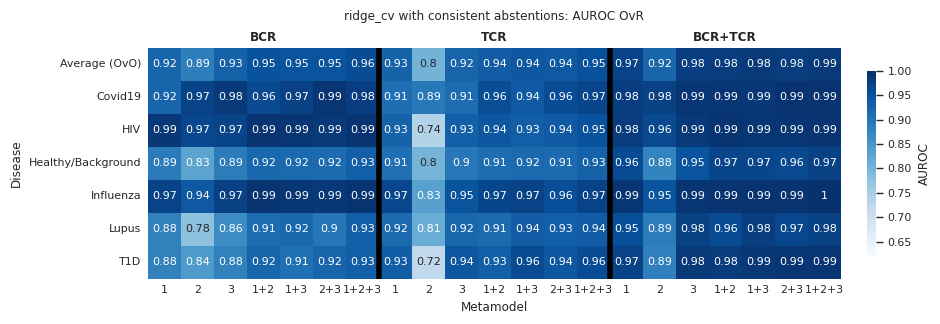

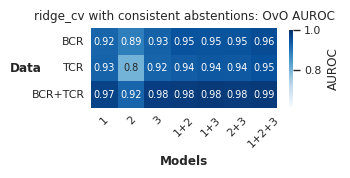

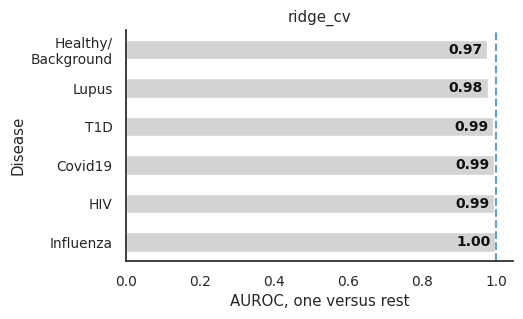

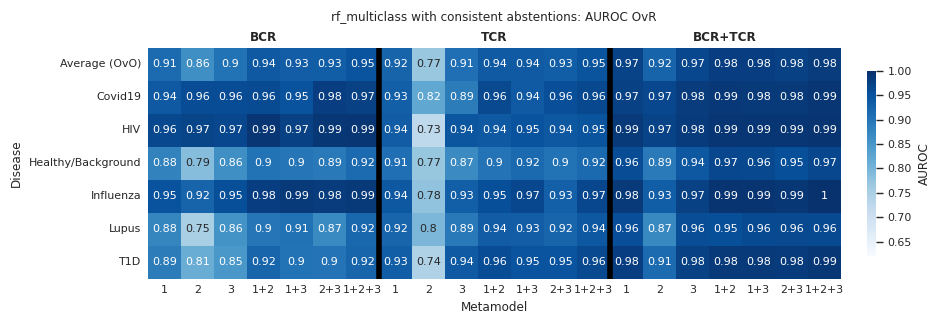

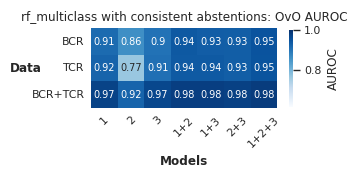

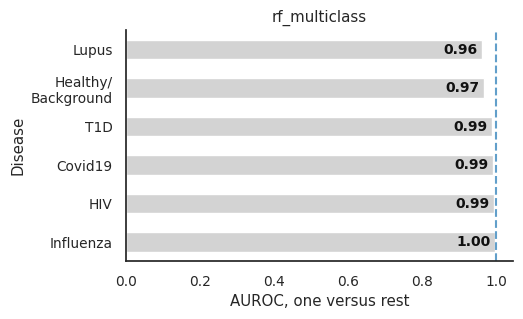

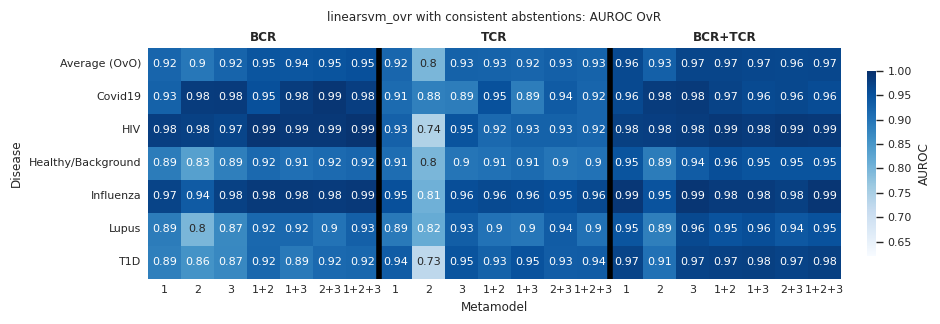

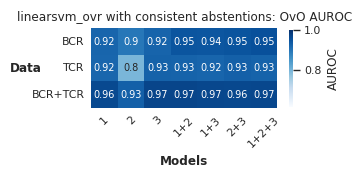

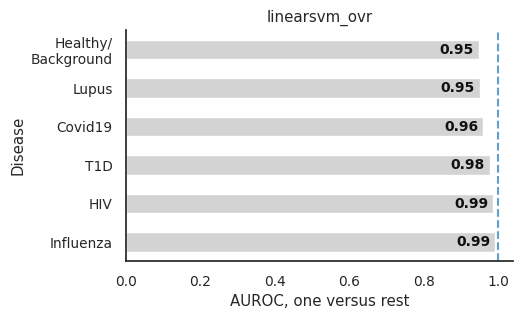

In [15]:
models_of_interest = [
    "lasso_cv",
    "elasticnet_cv",
    "ridge_cv",
    "rf_multiclass",
    "linearsvm_ovr",
]

# get plot_df for each model
models_of_interest = {
    model_name: subset_for_model(model_name) for model_name in models_of_interest
}

# find vmin across all models, so we can have consistent colormaps
vmin_global = np.nanmin(
    np.stack([plot_df.values for (plot_df, _) in models_of_interest.values()])
)

for model_name, (plot_df, tuple_columns) in models_of_interest.items():
    # display(plot_df.T)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(30, 3))
        heatmap = sns.heatmap(
            plot_df,
            cmap="Blues",
            square=True,
            cbar_kws={"shrink": 0.8, "label": "AUROC"},
            linewidths=0,
            ax=ax,
            # force all tick labels to be drawn
            xticklabels=True,
            yticklabels=True,
            # put values inside the heatmap
            annot=True,
            fmt=".2g",
            annot_kws={"size": 8},  # smaller font size
            # make colormaps consistent
            vmin=vmin_global,
            vmax=1.0,
        )

        xticklabels = ax.set_xticklabels(
            # ax.get_xticklabels(),
            # Instead of using full xticklabels, remove the BCR,TCR,BCR+TCR newline
            [model for model, locus in tuple_columns],
            rotation=0,
        )
        yticklabels = ax.set_yticklabels(
            ax.get_yticklabels(),
            rotation=0,
        )

        # Move the ticks closer to plot: reduce padding
        for axis in ["x", "y"]:
            ax.tick_params(axis=axis, which="major", pad=0)

        ax.set_xlabel("Metamodel")
        ax.set_ylabel("Disease")
        ax.set_title(
            f"{model_name} with consistent abstentions: AUROC OvR",
            # Adjust title position upwards
            pad=20,
        )

        # Identify the starting position for each locus group (BCR, TCR, BCR+TCR)
        def _get_first_true_index(arr):
            """Get index of first occurence of True"""
            return np.argmax(arr == True)

        first_index_of_each_locus = {
            locus: _get_first_true_index(
                plot_df.columns.str.contains(locus, regex=False)
            )
            for locus in locus_order
        }
        size_of_each_group = len(model_order)
        if "BCR+TCR" in first_index_of_each_locus.keys():
            assert first_index_of_each_locus["BCR"] == 0
            assert (
                first_index_of_each_locus["BCR"]
                < first_index_of_each_locus["TCR"]
                < first_index_of_each_locus["BCR+TCR"]
            )
            assert (
                first_index_of_each_locus["TCR"]
                == first_index_of_each_locus["BCR"] + size_of_each_group
            )
            assert (
                first_index_of_each_locus["BCR+TCR"]
                == first_index_of_each_locus["TCR"] + size_of_each_group
            )

        # Draw group separator lines: https://stackoverflow.com/a/39353190/130164
        ymin, ymax = ax.get_ylim()
        ax.vlines(
            x=[first_index_of_each_locus[locus] for locus in locus_order[1:]],
            ymin=ymin,
            ymax=ymax,
            colors="k",
            linewidth=4,
        )

        # Add group labels
        for label, pos in first_index_of_each_locus.items():
            ax.text(
                pos + size_of_each_group / 2,
                -0.3,
                label,
                ha="center",
                va="center",
                fontweight="bold",
            )

        # Move the colorbar closer to the heatmap
        cbar = heatmap.collections[0].colorbar
        pos = cbar.ax.get_position()  # [x, y, width, height]
        new_cbar_pos = [pos.x0 - 0.03, pos.y0, pos.width, pos.height]
        cbar.ax.set_position(new_cbar_pos)

        display(fig)
        genetools.plots.savefig(
            fig,
            config.paths.second_stage_blending_metamodel_output_dir
            / f"{target_obs_column.name}.roc_auc_per_class.{model_name}.png",
            dpi=300,
        )
        plt.close(fig)

        ####
        # Plot OvO only as a summary figure
        fig, ax = plt.subplots(figsize=(3, 2))
        heatmap = sns.heatmap(
            data=pd.Series(
                plot_df.loc["Average (OvO)"].to_numpy(),
                index=pd.MultiIndex.from_tuples(
                    tuple_columns, names=["Models", "Data"]
                ),
                name="value",
            )
            .unstack(level=0)
            .loc[locus_order][model_order],
            cmap="Blues",
            square=True,
            cbar_kws={"shrink": 0.5, "label": "AUROC"},
            linewidths=0,
            ax=ax,
            # force all tick labels to be drawn
            xticklabels=True,
            yticklabels=True,
            # put values inside the heatmap
            annot=True,
            fmt=".2g",
            annot_kws={"size": 7},  # smaller font size
            # make colormaps consistent
            vmin=vmin_global,
            vmax=1.0,
        )
        yticklabels = ax.set_yticklabels(
            ax.get_yticklabels(),
            rotation=0,
        )

        ax.set_ylabel(
            ax.get_ylabel(), rotation=0, verticalalignment="center", fontweight="bold"
        )
        ax.set_xlabel(ax.get_xlabel(), fontweight="bold")

        # Move the ticks closer to plot: reduce padding
        ax.tick_params(axis="x", which="major", pad=0, rotation=45)
        ax.tick_params(axis="y", which="major", pad=0)

        ax.set_title(
            f"{model_name} with consistent abstentions: OvO AUROC",
        )
        display(fig)
        genetools.plots.savefig(
            fig,
            config.paths.second_stage_blending_metamodel_output_dir
            / f"{target_obs_column.name}.roc_auc_per_class.{model_name}.ovo_summary.png",
            dpi=300,
        )
        genetools.plots.savefig(
            fig,
            config.paths.second_stage_blending_metamodel_output_dir
            / f"{target_obs_column.name}.roc_auc_per_class.{model_name}.ovo_summary.pdf",
            dpi=600,
        )
        plt.close(fig)

        ####
        # Plot each row (each class) one by one as additional summary figures
        for name, row in plot_df.iterrows():
            fig, ax = plt.subplots(figsize=(3, 2))
            heatmap = sns.heatmap(
                data=pd.Series(
                    row.to_numpy(),
                    index=pd.MultiIndex.from_tuples(
                        tuple_columns, names=["Models", "Data"]
                    ),
                    name="value",
                )
                .unstack(level=0)
                .loc[locus_order][model_order],
                cmap="Blues",
                square=True,
                cbar_kws={"shrink": 0.5, "label": "AUROC"},
                linewidths=0,
                ax=ax,
                # force all tick labels to be drawn
                xticklabels=True,
                yticklabels=True,
                # put values inside the heatmap
                annot=True,
                fmt=".2g",
                annot_kws={"size": 7},  # smaller font size
                # make colormaps consistent
                vmin=vmin_global,
                vmax=1.0,
            )
            yticklabels = ax.set_yticklabels(
                ax.get_yticklabels(),
                rotation=0,
            )

            ax.set_ylabel(
                ax.get_ylabel(),
                rotation=0,
                verticalalignment="center",
                fontweight="bold",
            )
            ax.set_xlabel(ax.get_xlabel(), fontweight="bold")

            # Move the ticks closer to plot: reduce padding
            ax.tick_params(axis="x", which="major", pad=0, rotation=45)
            ax.tick_params(axis="y", which="major", pad=0)

            ax.set_title(
                f"{model_name} with consistent abstentions: {name}",
            )
            genetools.plots.savefig(
                fig,
                config.paths.high_res_outputs_dir
                / "metamodel"
                / f"{target_obs_column.name}.roc_auc_per_class.{model_name}.{slugify(name)}.png",
                dpi=300,
            )
            genetools.plots.savefig(
                fig,
                config.paths.high_res_outputs_dir
                / "metamodel"
                / f"{target_obs_column.name}.roc_auc_per_class.{model_name}.{slugify(name)}.pdf",
                dpi=600,
            )
            plt.close(fig)

        ####
        # Plot final per-class AUROC of full ensemble
        with sns.plotting_context("notebook", font_scale=0.9):
            fig, ax = plt.subplots(figsize=(5, 3))
            all_loci_together = locus_order[-1]  # BCR+TCR if available
            ax = sns.barplot(
                data=plot_df[f"1+2+3\n{all_loci_together}"]
                .drop("Average (OvO)")
                .sort_values()
                .to_frame(name="AUROC, one versus rest")
                .rename_axis(index="Disease")
                .reset_index(),
                x="AUROC, one versus rest",
                y="Disease",
                color="lightgrey",
                width=0.5,
                ax=ax,
            )
            ax.bar_label(
                ax.containers[0],
                fontsize=10,
                label_type="edge",
                padding=-28,
                color="#111111",
                fontweight="bold",
                fmt="%0.2f",
            )
            sns.despine(ax=ax)
            genetools.plots.wrap_tick_labels(
                ax=ax, wrap_x_axis=False, wrap_y_axis=True, wrap_amount=10
            )
            plt.axvline(1, linestyle="dashed", alpha=0.7)
            plt.title(f"{model_name}")
            display(fig)
            genetools.plots.savefig(
                fig,
                config.paths.second_stage_blending_metamodel_output_dir
                / f"{target_obs_column.name}.roc_auc_per_class.{model_name}.final.png",
                dpi=300,
            )
            genetools.plots.savefig(
                fig,
                config.paths.second_stage_blending_metamodel_output_dir
                / f"{target_obs_column.name}.roc_auc_per_class.{model_name}.final.pdf",
                dpi=600,
            )
            plt.close(fig)